In [1]:
import sys
import os

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch

# import some common libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def cv2_imshow( im ):
    cv2.imshow('',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

things = MetadataCatalog.get("coco_2017_train").thing_classes
print(things)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [2]:
##### CAMERA CALIBRATION CONFIG - this configuration comes from how we set up Cameras in CARLA
baseline_F = 0.8 # 80cm on top car
baseline_LC = np.sqrt([0.2*0.2 *2])[0] # left corner
baseline_RC = np.sqrt([0.2*0.2 *2])[0] # right corner
baseline_L = 0.5 # left side
baseline_R = 0.5 # right side

# rotation matrices

# translation matrices (first swap then rotate then translate : F * R)
translate_F = torch.tensor([[1.,0,0,-0.3],[0,1.,0,0.4],[0,0,1.,-1.0],[0,0,0,1.]])

# {"x": z, "y": x, "z": y } Switch between CARLA UE and image coordinate system
swap_axes = torch.tensor([[0,0,1.0,0],[1,0,0,0],[0,1.0,0,0],[0,0,0,1.]])

# full transforms matrices
transform_F = torch.mm(translate_F, swap_axes)

# camera properties
fov=90
W=1280
H=720

fov = fov / 360. * 2. * np.pi
f = W / (2. * np.tan(fov / 2.))  # focus length

In [3]:
########### CONFIGURE DETECTRON
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [4]:
########### CONFIGURE STEREO MATCHER
num_disp = 128
window_size = 11
stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size )
stereo.setUniquenessRatio(5)

In [5]:
########### CONFIGURE PATH AND JSON LOGGER
from actorlogger import ActorLogger, Frame
path = "/home/najib/Thesis/Rendering/" + str(3)
subpath = path + "/out/"
saveimpath = path + "/det/"
os.makedirs(saveimpath, exist_ok=True)
actorLogger = ActorLogger(path)

In [8]:
# Depth image saver
dpi = 72
figsize = W / float(dpi), H / float(dpi)
def saveDepth(disparity, path):
    fig = plt.figure(figsize=figsize,frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(disparity, aspect='auto')
    plt.savefig(path, bbox_inches='tight',transparent=True, pad_inches=0)
    plt.close()    

In [9]:
import re
from PIL import Image
import time

In [29]:
## First frame
sortedPaths = sorted(os.listdir(subpath))
frame_id = int(re.search(r'\d+', sortedPaths[0]).group())
print("First frame: ", frame_id, " last frame: ", re.search(r'\d+', sortedPaths[-1]).group())

start_time = time.time()

fpsl = torch.tensor([])

while(os.path.exists((subpath + str(frame_id) + 'FL.jpg'))):
    frame = Frame(frame_id)
    print("Processing frame ", frame_id)
    print("FPS avg: ", fpsl.mean().cpu().numpy())

    # Read front stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'FL.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'FR.jpg')

    # Hide ego car from image
    imgL[630:H, 410:W] = [0,0,0]
    imgR[630:H, 0:880] = [15,15,15]

    # Calculate disparity with stereo block matching algorithm
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    # save image
#     saveDepth(disparity, ('%s/%d%s.jpg' % (saveimpath, frame_id, "DP")))

    # Predict detections with detectron2
    outputs = predictor(imgL)
    
    # save image
#     v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     detim = v.get_image()
#     Image.fromarray(detim, 'RGB').save(('%s/%d%s.jpg' % (saveimpath, frame_id, "DET")), 'JPEG', quality=85)
    

    # Detect actors
    for i in range(0, len(outputs["instances"])):
        
        if(outputs["instances"].pred_classes[i] not in (0,1,2,3,4,5,6,7)): # Detect only these classes
            continue

        # Mask actor depth
        mask = outputs["instances"].pred_masks[i]
        masked = torch.tensor(disparity)[mask]
        nonnegative = masked > 0  # negative values in depth map mean unmatched regions
        disparities = masked[nonnegative]

        if(disparities.nelement() == 0 or torch.isnan(mean_disparity)):
            mean_disparity = torch.tensor(0.1)
        else:
            mean_disparity = disparities.mode().values # Mean of depth
            
        # Inverse projection
        [[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
        dx = cx - W/2
        dy = cy - H/2
        z = f*baseline_F/mean_disparity
        x = dx*z/f
        y = dy*z/f
        
        # Swap axes to RL coordinates and translate
        pos = torch.tensor([x,y,z,1])
        [x,y,z, _] = torch.mv(transform_F,pos)
        
        x = float(x)
        y = float(y)
        z = float(z)
        frame.addActor("", things[outputs["instances"].pred_classes[i]], 0, {"x": x, "y": y, "z": z })


    actorLogger.addFrame(frame)
    frame_id += 1
    
    fpsl = torch.cat((fpsl, torch.tensor([1.0 / (time.time() - start_time)])), 0)
    start_time = time.time()    

actorLogger.save()


First frame:  170  last frame:  707
Processing frame  170
FPS avg:  nan
Processing frame  171
FPS avg:  0.8175236
Processing frame  172
FPS avg:  0.8126695
Processing frame  173
FPS avg:  0.83449054
Processing frame  174
FPS avg:  0.8465856
Processing frame  175
FPS avg:  0.853236
Processing frame  176
FPS avg:  0.8507989
Processing frame  177
FPS avg:  0.8541579
Processing frame  178
FPS avg:  0.8536868
Processing frame  179
FPS avg:  0.853631
Processing frame  180
FPS avg:  0.8576639
Processing frame  181
FPS avg:  0.8592506
Processing frame  182
FPS avg:  0.8578716
Processing frame  183
FPS avg:  0.85715836
Processing frame  184
FPS avg:  0.85763866
Processing frame  185
FPS avg:  0.85747474
Processing frame  186
FPS avg:  0.85852283
Processing frame  187
FPS avg:  0.8589543
Processing frame  188
FPS avg:  0.85978967
Processing frame  189
FPS avg:  0.860511
Processing frame  190
FPS avg:  0.8614237
Processing frame  191
FPS avg:  0.8630172
Processing frame  192
FPS avg:  0.8645493
P

Processing frame  363
FPS avg:  0.8366251
Processing frame  364
FPS avg:  0.8365459
Processing frame  365
FPS avg:  0.83643657
Processing frame  366
FPS avg:  0.8363518
Processing frame  367
FPS avg:  0.8360316
Processing frame  368
FPS avg:  0.8356421
Processing frame  369
FPS avg:  0.8353319
Processing frame  370
FPS avg:  0.83521754
Processing frame  371
FPS avg:  0.8350738
Processing frame  372
FPS avg:  0.8348939
Processing frame  373
FPS avg:  0.8346941
Processing frame  374
FPS avg:  0.8346278
Processing frame  375
FPS avg:  0.83453995
Processing frame  376
FPS avg:  0.8344771
Processing frame  377
FPS avg:  0.8344355
Processing frame  378
FPS avg:  0.8343909
Processing frame  379
FPS avg:  0.8343481
Processing frame  380
FPS avg:  0.8342889
Processing frame  381
FPS avg:  0.8342363
Processing frame  382
FPS avg:  0.83416134
Processing frame  383
FPS avg:  0.83405876
Processing frame  384
FPS avg:  0.8339876
Processing frame  385
FPS avg:  0.8339562
Processing frame  386
FPS avg

Processing frame  557
FPS avg:  0.83358425
Processing frame  558
FPS avg:  0.8336223
Processing frame  559
FPS avg:  0.83363694
Processing frame  560
FPS avg:  0.83366066
Processing frame  561
FPS avg:  0.8336759
Processing frame  562
FPS avg:  0.83366776
Processing frame  563
FPS avg:  0.8336444
Processing frame  564
FPS avg:  0.8336078
Processing frame  565
FPS avg:  0.833564
Processing frame  566
FPS avg:  0.8335435
Processing frame  567
FPS avg:  0.83353573
Processing frame  568
FPS avg:  0.8335154
Processing frame  569
FPS avg:  0.83349633
Processing frame  570
FPS avg:  0.8334781
Processing frame  571
FPS avg:  0.83345675
Processing frame  572
FPS avg:  0.83344835
Processing frame  573
FPS avg:  0.8334297
Processing frame  574
FPS avg:  0.8334019
Processing frame  575
FPS avg:  0.8333924
Processing frame  576
FPS avg:  0.83320963
Processing frame  577
FPS avg:  0.8330878
Processing frame  578
FPS avg:  0.83299726
Processing frame  579
FPS avg:  0.8329588
Processing frame  580
FPS

In [1]:
actorLogger.save()

NameError: name 'actorLogger' is not defined

tensor(660.0953, device='cuda:0') tensor(293.0743, device='cuda:0')
41.72052001953125 1.7194007635116577 -5.394145965576172


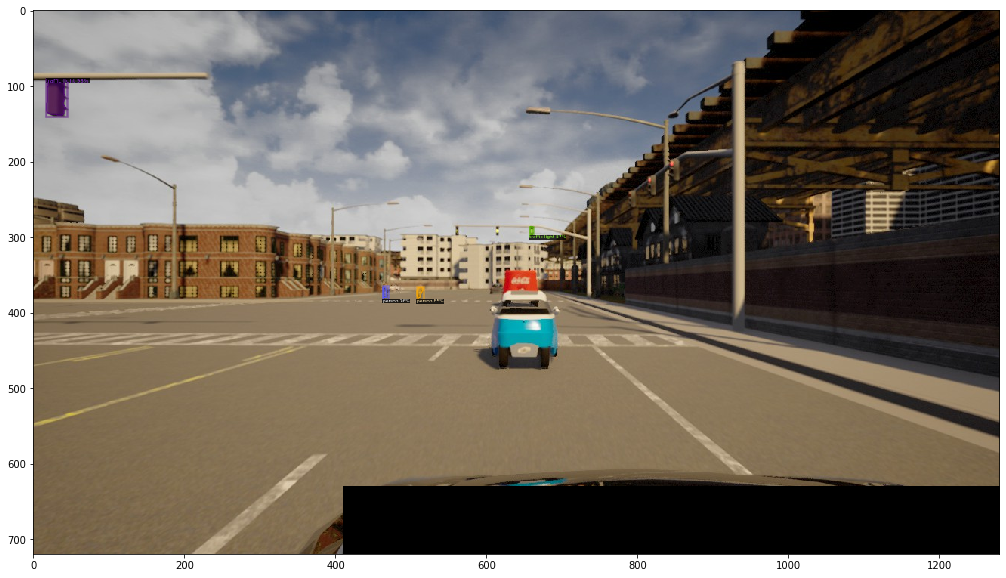

In [6]:
imgL = cv2.imread('/home/najib/Thesis/Rendering/3/out/260FL.jpg')
imgR = cv2.imread('/home/najib/Thesis/Rendering/3/out/260FR.jpg')

imgL[630:H, 410:W] = [0,0,0]
imgR[630:H, 0:880] = [15,15,15]

outputs = predictor(imgL)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# outputs["instances"].pred_boxes[0]

i =3
[[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
print(cx, cy)

grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
disparity = (disp)

mask = outputs["instances"].pred_masks[i]
masked = torch.tensor(disparity)[mask]
nonnegative = masked > 0  # negative values in depth map mean unmatched regions
mean_disparity = masked[nonnegative].mean()

if(torch.isnan(mean_disparity)):
    mean_disparity = torch.tensor(0.1)

# Inverse projection
dx = cx - W/2
dy = cy - H/2
z = f*baseline_F/mean_disparity
x = dx*z/f
y = dy*z/f

# Swap axes to RL coordinates and translate
pos = torch.tensor([x,y,z,1])
[x,y,z, _] = torch.mv(transform_F,pos)

x = float(x)
y = float(y)
z = float(z)

print(x,y,z)


v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
detim = v.get_image()
plt.figure(figsize=(20,10))
plt.imshow(detim)